Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Mnist-denoising.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FMnist-denoising.ipynb&branch=main" target="_blank">Rosenblatt</a>

# TP 1.  Adaptation d'un réseau CNN pour le débruitage et l'inpainting

Dans ce TP, on va utiliser un réseau CNN basique pour tester sa capacité à effectuer du débruitage ou de l'inpainting.
<br>
<br>
<br>
## Imports des librairies et configuration

In [3]:
#imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Hyper parameters
num_epochs = 1
batch_size = 16
learning_rate = 0.001

dataroot = '/home/jupyter-glaunes/data_M2MMAS/'

device: cuda:0


## Datasets d'images

In [4]:

dataset = "MNIST" # "FER2013" # "Imagenette" # "CIFAR10" # 

if dataset == "MNIST":
    train_dataset = torchvision.datasets.MNIST(root=dataroot, train=True,
                                              transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.MNIST(root=dataroot, train=False,
                                             transform=transforms.ToTensor())
    n_channels = 1
elif dataset == "CIFAR10":
    train_dataset = torchvision.datasets.CIFAR10(root=dataroot, train=True,
                                              transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.CIFAR10(root=dataroot, train=False,
                                             transform=transforms.ToTensor())
    n_channels = 3
elif dataset == "FER2013":
    train_dataset = torchvision.datasets.FER2013(root=dataroot, split="train",
                                              transform=transforms.ToTensor())
    test_dataset = torchvision.datasets.FER2013(root=dataroot, split="test",
                                             transform=transforms.ToTensor())
    n_channels = 1
elif dataset == "Imagenette":
    transform=transforms.Compose([transforms.ToTensor(),
                                transforms.RandomCrop(size=(20,32),pad_if_needed=True)])
    train_dataset = torchvision.datasets.Imagenette(root=dataroot, split="train",
                                                   transform=transform)
    test_dataset = torchvision.datasets.Imagenette(root=dataroot, split="val",
                                                  transform=transform)
    n_channels = 3

In [5]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

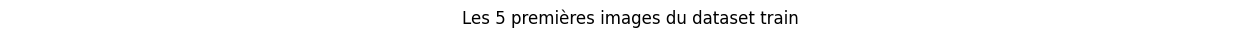

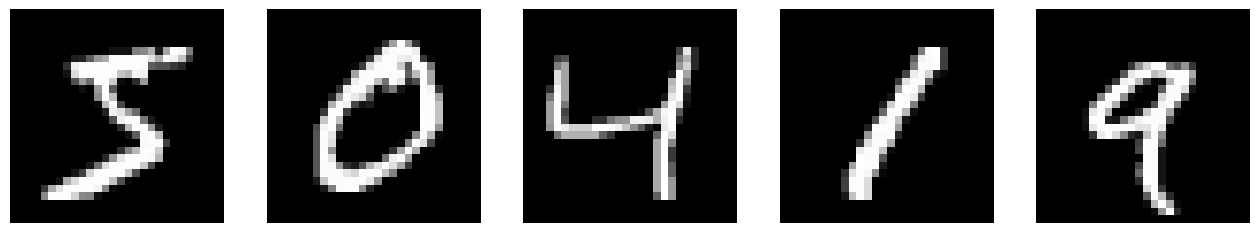

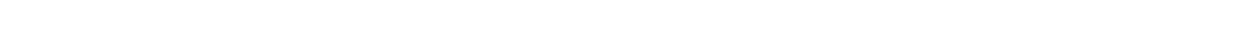

In [6]:
# affichage de quelques images
def show_images(images, nrows=1, title=None):
    nb_ims = images.shape[0]
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.1))
    plt.axis("off")
    plt.title(title)
    plt.show()
    ncols = math.ceil(nb_ims/nrows)
    for k in range(nb_ims):
       plt.subplot(nrows, ncols, k+1)
       plt.imshow(images[k].permute((1,2,0)), cmap="gray")
       plt.axis("off")
    plt.show()
    plt.figure(figsize=(plt.rcParams['figure.figsize'][0],0.3))
    plt.axis("off")
    plt.show()

def load_batch(dataset, n):
  return torch.stack([dataset[k][0] for k in range(n)])

train_images_sample = load_batch(train_dataset, 5)
show_images(train_images_sample, title="Les 5 premières images du dataset train")

## Fonctions pour simuler la dégradation des images

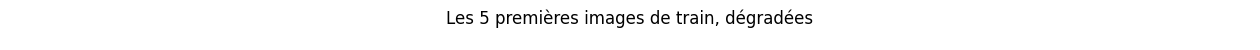

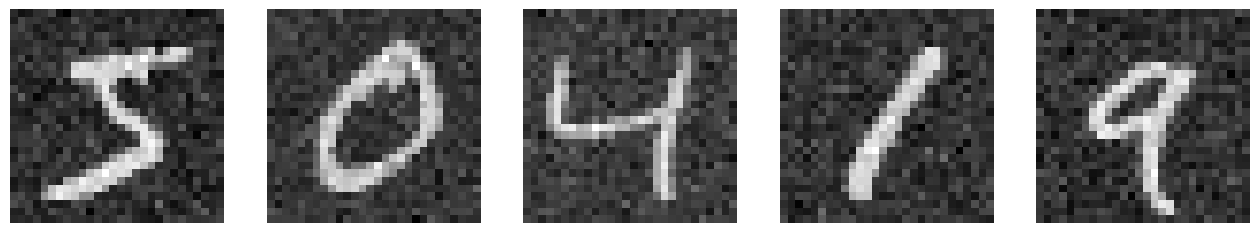

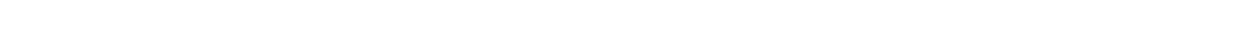

In [7]:
# bruit gaussien
def gaussian_noise(images,sigma=.1):
    return images + torch.randn(images.shape, device=images.device)*sigma

# bruit "Salt and Pepper"
def salt_and_pepper(images,prob=.1):
    images_noisy = images.clone().permute((0,2,3,1))
    rnd = torch.rand(images_noisy.shape[:-1])
    images_noisy[rnd<prob,:] = 0
    images_noisy[rnd>1-prob,:] = 1
    return images_noisy.permute((0,3,1,2))

# suppression d'un bloc de pixel (pour l'inpainting)
def random_remove(images, size=(16,16)):
    images_out = images.clone().permute((0,2,3,1))
    i = torch.randint(images_out.shape[1]-size[0], (images_out.shape[0],))
    j = torch.randint(images_out.shape[2]-size[0], (images_out.shape[0],))
    for k in range(images_out.shape[0]):
        images_out[k,i[k]:(i[k]+size[0]),j[k]:(j[k]+size[1]),:] = 0
    return images_out.permute((0,3,1,2))

corrupt_fun = gaussian_noise
#corrupt_fun = lambda x : gaussian_noise(x,sigma=1)
#corrupt_fun = lambda x : salt_and_pepper(x,prob=.4)
#corrupt_fun = random_remove

train_images_sample_noisy = corrupt_fun(train_images_sample)
show_images(train_images_sample_noisy, title="Les 5 premières images de train, dégradées")

## Définition du réseau

__Question 1__. En vous basant sur le modèle du notebook de classification du dataset MNIST, définir un réseau CNN simple permetant d'effectuer une tache de débruitage. La modification essentielle à apporter est que la sortie du réseau doit être de la même taille que l'entrée, puisqu'ici les labels de la tache de classification sont remplacés par les images débruitées. D'autre part, on veut que le réseau puisse fonctionner avec un nombre de canaux d'entrée quelconque (argument `n_channels` en entrée) pour pouvoir traiter à la fois les images en niveaux de gris et en couleurs.

In [ ]:
# Réseau CNN
class ConvNet(nn.Module):
    def __init__(self, n_channels):
        super(ConvNet, self).__init__()
        ## to do ##

    def forward(self, x):
        ## to do ##

model = ConvNet(n_channels).to(device)

## Fonction de perte et optimiseur

Ici la fonction de perte (loss function) est différente, puisqu'on ne compare plus des classes mais des images. On peut utiliser le critère des moindres carrés : Mean Square Error (MSE) loss.

In [ ]:
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Entraînement du réseau. 

In [ ]:
# Entraînement du réseau

print("beginning training...")
total_step = len(train_loader)
rec_loss = np.zeros((num_epochs,len(train_loader)))
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        images_noisy = corrupt_fun(images)

        # Forward pass
        outputs = model(images_noisy)
        loss = lossfun(outputs,images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rec_loss[epoch,i] = loss.item()

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
print("training done")
plt.plot(rec_loss.flatten())
plt.title("loss vs iterations")

<br>
<br>
<br>
On affiche la sortie du réseau pour cinq images test. Ces sorties sont censées être des images très proches des images d'entrée car le réseau a été entraîné pour ça.

In [ ]:
test_images_sample = load_batch(test_dataset, 5)
test_images_sample_corrupt = corrupt_fun(test_images_sample)

outputs = model(test_images_sample_corrupt.to(device)).detach().cpu()

show_images(test_images_sample_corrupt, title="Les 5 premières images test, dégradées (entrée du réseau)")
show_images(outputs, title="sorties du réseau")
show_images(test_images_sample, title="Les 5 premières images test")

__Question 2.__ Tester le réseau avec des niveaux de bruits différents, pour le bruit gaussien et le bruit salt-and-pepper. Tester également le réseau pour la tache d'inpainting (fonction `random_remove`)

__Question 3.__ Tester également avec les différents datasets disponibles, pour des niveaux de bruits assez élevés. Que peut-on remarquer ?

__Question 4.__ Modifier la définition du réseau afin qu'il puisse avoir un nombre de couches quelconque, fourni en entrée (`def __init__(self, n_channels, n_layers):`), en choisissant une configuration cohérente pour les dimensions des couches internes. 

__Question 5.__ Tester le bénéfice obtenu en augmentant la profondeur du réseau, sur les taches les plus difficiles.